In [1]:
import spotipy
import pandas as pd
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split 
from logistic_regression import LogisticRegression 
from gaussian_naive_bayes import GaussianNaiveBayes
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Data Acquisition

<p style="text-align: justify">The function <code>get_playlist_tracks</code> calls the Spotify Web API and retrieves all the tracks from a given playlist and its selected audio features: acousticness, danceability, energy, instrumentalness, valence and speechiness.</p>

In [2]:
def get_playlist_tracks(uri, features_of_interest):
    playlist = sp.user_playlist_tracks(uri.split(':')[2], uri.split(':')[4])
    tracks = playlist['items']
    list_of_ids = []
    list_of_names = []
    features_per_track = {}
    while playlist['next']:
        playlist = sp.next(playlist)
        tracks.extend(playlist['items'])
    for track in tracks:
        list_of_ids.append((track['track']['id']))
        list_of_names.append((track['track']['name']))
    for n, (track_id, track_name) in enumerate(zip(list_of_ids, list_of_names)): 
        features = dict((key,value) for key, value in sp.audio_features(track_id)[0].items() if key in features_of_interest)
        features['track_id'] = track_id
        features['playlist_id'] = uri.split(':')[4]
        features_per_track[n] = features
    return pd.DataFrame.from_dict(features_per_track, orient='index')

<p style="text-align: justify">The data used in this work contains 743 observations and was compiled using the script bellow. It has been previously saved in the <code>dataset.csv</code>.</p>

In [3]:
try:
    client_credentials_manager = SpotifyClientCredentials(client_id = 'bddfdc9233b5493899809dcc42ca5cc3', client_secret = 'd97a1e581b5f4b4b9da348d6a0529e02')
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    audio_features = ['danceability', 'energy','speechiness', 'acousticness','instrumentalness', 'valence']
    uri_rap = 'spotify:user:spotifycharts:playlist:4NvVpXZLIZ4z5yzTIqgLve'
    uri_jazz = 'spotify:user:spotifycharts:playlist:1Rj92hyXm3WjpOJI8XgYtF'
    rap = get_playlist_tracks(uri_rap, audio_features) ##retrieves 'Best of Rap'
    jazz = get_playlist_tracks(uri_jazz, audio_features) ##retrieves 'Cafe Jazz'
    frames = [rap, jazz]
    result = pd.concat(frames).reset_index().drop('index', 1) ##concatenate the Dataframes
    result.to_csv('dataset.csv', index=False)
except:
    print("No credentials!")

### 2. Data Analysis

<p style="text-align: justify">The following table summarizes the central tendency and dispersion of the audio features.</p>

In [24]:
data = pd.read_csv('dataset.csv')
data_trans = data.copy()
data_trans.loc[data['playlist_id'] == '4NvVpXZLIZ4z5yzTIqgLve', 'playlist_id'] = 0 ##rap
data_trans.loc[data['playlist_id'] == '1Rj92hyXm3WjpOJI8XgYtF', 'playlist_id'] = 1 ##jazz
data_trans.loc[:, 'danceability':'valence'].describe()

,danceability,energy,speechiness,acousticness,instrumentalness,valence
count,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000
mean,0.686192,0.522988,0.157569,0.449509,0.116524,0.569812
std,0.139436,0.221335,0.132347,0.342396,0.266617,0.210077
min,0.265000,0.043800,0.025400,0.000136,0.000000,0.041100
25%,0.597500,0.335500,0.040900,0.103000,0.000000,0.416000
50%,0.697000,0.524000,0.091200,0.425000,0.000022,0.588000
75%,0.794500,0.710000,0.270000,0.798500,0.010350,0.735500
max,0.959000,0.978000,0.681000,0.991000,0.976000,0.975000


<p style="text-align: justify">And the graph below visually illustrates the central tendency of the audio attributes for each playlist and how it varies compared to the overall average value. Acousticness and instrumentalness are the two attributes that varied the most. The average valence, on the other hand, varied the least.</p> 

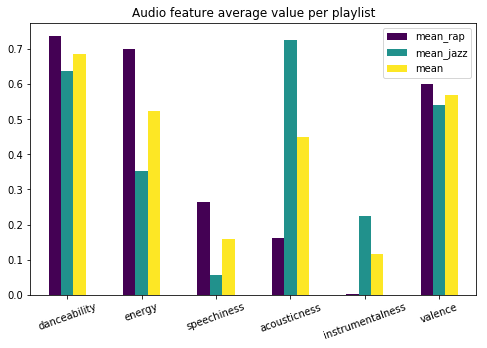

In [5]:
audio_features = ['danceability', 'energy', 'speechiness', 'acousticness','instrumentalness', 'valence']
all_playlists = data_trans[audio_features].describe().T

rap = data_trans.loc[data_trans['playlist_id'] == 0][audio_features].describe().T
rap.rename(columns={'mean':'mean_rap'}, inplace=True)

jazz = data_trans.loc[data_trans['playlist_id'] == 1][audio_features].describe().T
jazz.rename(columns={'mean':'mean_jazz'}, inplace=True)

df1 = rap['mean_rap']
df2 = jazz['mean_jazz']
df3 = all_playlists['mean']

r = pd.concat([df1, df2, df3], axis=1)
r.plot(kind='bar', figsize=(8,5), title='Audio feature average value per playlist', colormap='viridis', rot=20);

<p style="text-align: justify">The dataset is split into training and testing sets with a ratio of 'test_size' using the scikit-learn's implementation.</p>

In [18]:
features = data_trans.loc[:, 'danceability':'valence'].values
targets = data_trans.loc[:, 'playlist_id'].values
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.1, random_state=100)

### 3. Logistic Regression

In [19]:
lr = LogisticRegression(iterations=15000, learning_rate=0.10)
pred_y = lr.fit(x_train, y_train).predict(x_test)
accuracy_score(pred_y, y_test)

0.9743589743589743

In [20]:
confusion_matrix(y_test, pred_y)

array([[44,  0],
       [ 2, 32]])

### 4. Gaussian Naïve Bayes

In [21]:
gnb = GaussianNaiveBayes()
pred_y = gnb.fit(x_train, y_train).predict(x_test)
accuracy_score(y_test, pred_y)

0.9615384615384616

In [22]:
confusion_matrix(y_test, pred_y)

array([[44,  0],
       [ 3, 31]])